In [1]:
# git clone git://github.com/holoviz/datashader.git
# cd datashader
# conda env create --name datashader --file ./examples/environment.yml
# conda activate datashader

In [2]:
import glob
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]


In [3]:
import seaborn as sns
import math

In [4]:
import os.path
# make sure our file exists
os.path.exists("deaths/kill_match_stats_final_0.csv")

True

In [5]:
def load_deaths():
    li = []
    for filename in glob.glob("deaths/*.csv"):
        df = pd.read_csv(filename)
        df = df.drop(['match_id','victim_placement','killed_by','killer_name','killer_placement','victim_name'],axis='columns')
        li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True)
    return(df)

In [6]:
deaths_df = load_deaths()

In [7]:
deaths_df = deaths_df[deaths_df['map'] == "ERANGEL"]

In [8]:
deaths_df = deaths_df[~(deaths_df == 0).any(axis=1)]

In [9]:
deaths_df.map.value_counts()

ERANGEL    50341537
Name: map, dtype: int64

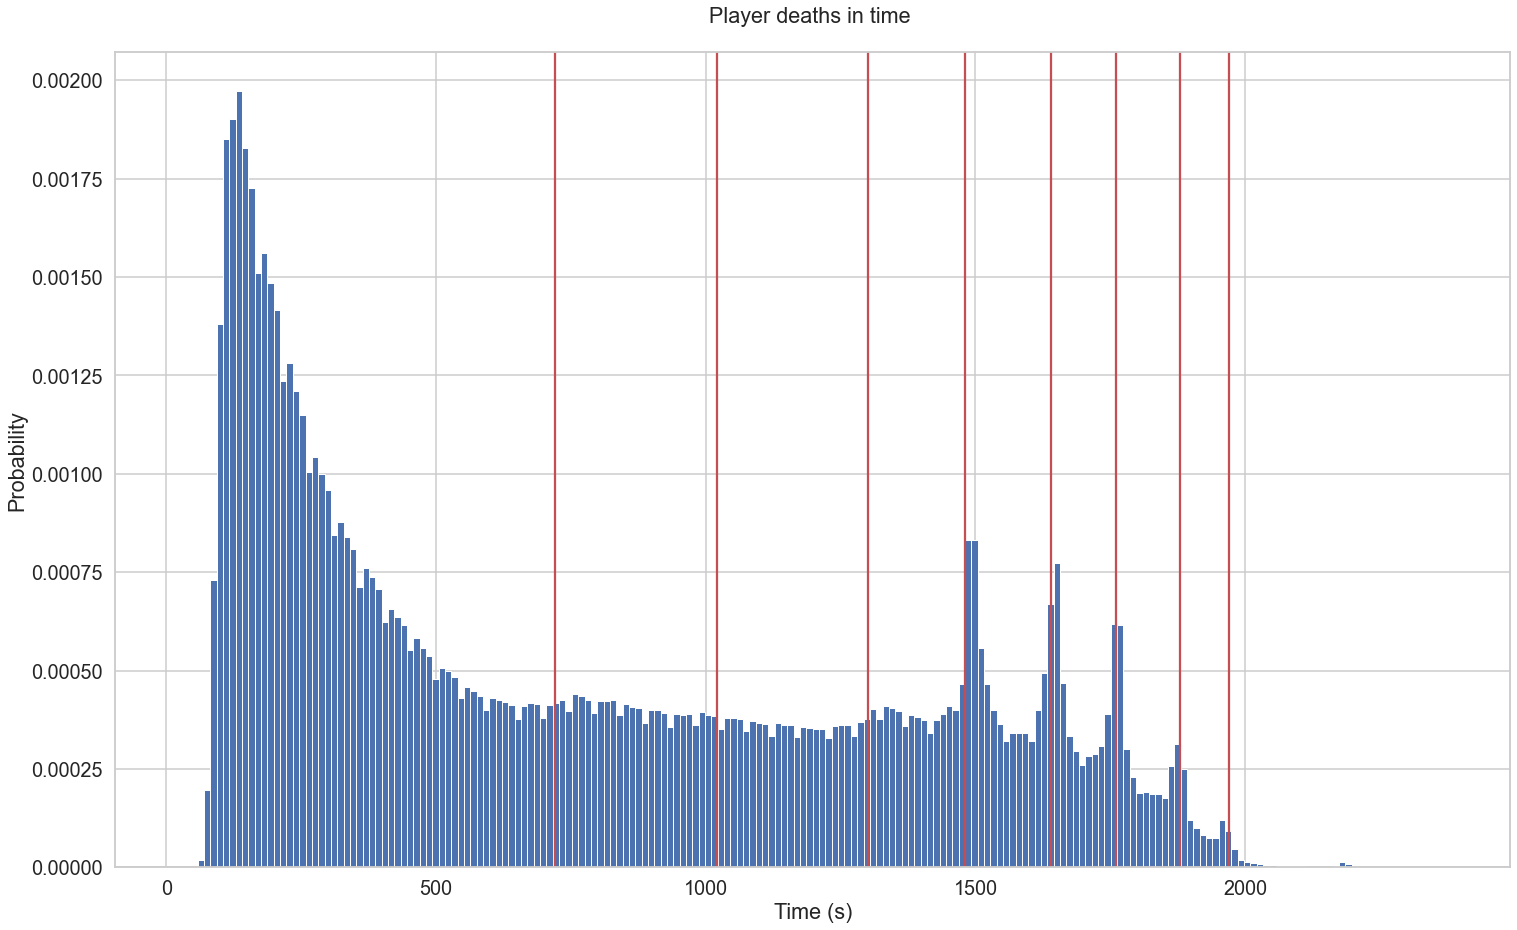

In [10]:
plt.figure(figsize=(25,15))
sns.set(style='whitegrid', context='talk', font_scale=1.2)
plt.hist(deaths_df["time"], density=True, bins=200, edgecolor='white', linewidth=1)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Time (s)');
plt.title("Player deaths in time \n")
plt.axvline(720, color='r');
plt.axvline(1020, color='r');
plt.axvline(1300, color='r');
plt.axvline(1480, color='r');
plt.axvline(1640, color='r');
plt.axvline(1760, color='r');
plt.axvline(1880, color='r');
plt.axvline(1970, color='r');

In [11]:
def create_phase_category(deaths_df):
    conditions = [
        (60<deaths_df.time) & (deaths_df.time<=720),
        (720<deaths_df.time) & (deaths_df.time<=1480),
        (1480<deaths_df.time)]
    choices = ['early', 'mid', 'late']
    deaths_df['phase'] = np.select(conditions, choices, default='very_early')
    deaths_df['phase'] = deaths_df['phase'].astype('category')
    
    return(deaths_df)

In [12]:
deaths_df = create_phase_category(deaths_df)

In [13]:
cvs = ds.Canvas(plot_width=4_000, plot_height=4_000, x_range=[0,800_000],y_range=[0,800_000])

In [14]:
agg = cvs.points(deaths_df, 'victim_position_x', 'victim_position_y',ds.count_cat('phase'))

In [15]:
deaths_df.victim_position_y = 800_000 - deaths_df.victim_position_y

In [16]:
color_key = {'very_early':'black', 'early':'lime',  'mid':'aqua', 'late':'fuchsia'}  
cvs = ds.Canvas(plot_width=4000, plot_height=4000, x_range=[0,800_000],y_range=[0,800_000])    
agg = cvs.points(deaths_df,'victim_position_x','victim_position_y',ds.count_cat('phase'))
# tf.set_background(img,"black", name="Black bg")

# uncomment to display image
# tf.set_background(tf.shade(agg, color_key=color_key, how='eq_hist'),"black", name="Black bg")

In [17]:
from colorcet import fire
cvs = ds.Canvas(plot_width=4000, plot_height=4000, x_range=[0,800_000],y_range=[0,800_000])
agg = cvs.points(deaths_df, 'victim_position_x', 'victim_position_y')
# uncomment to display image
# tf.set_background(tf.shade(agg, cmap=fire),"black")

In [18]:
deaths_df.columns

Index(['killer_position_x', 'killer_position_y', 'map', 'time',
       'victim_position_x', 'victim_position_y', 'phase'],
      dtype='object')

In [19]:
deaths_df.victim_position_y = 800_000 - deaths_df.victim_position_y

In [20]:
dist_test = (((deaths_df.loc[deaths_df.index[0], "killer_position_x"] - 
               deaths_df.loc[deaths_df.index[0], "killer_position_y"])**2 + 
             (deaths_df.loc[deaths_df.index[0], "victim_position_x"] - 
              deaths_df.loc[deaths_df.index[0], "victim_position_y"])**2)**0.5)
dist_test

248031.01434266238

In [21]:
deaths_df.head(1)

,killer_position_x,killer_position_y,map,time,victim_position_x,victim_position_y,phase
179,496989.8,312569.7,ERANGEL,1035,497385.4,331528.2,mid


In [22]:
x1 = deaths_df.loc[deaths_df.index[0], "killer_position_x"]
y1 = deaths_df.loc[deaths_df.index[0], "killer_position_y"]
x2 = deaths_df.loc[deaths_df.index[0], "victim_position_x"]
y2 = deaths_df.loc[deaths_df.index[0], "victim_position_y"]
print(x1, y1, x2, y2)
d = np.hypot(x2 - x1, y2 - y1)
print(d)

496989.8 312569.7 497385.4 331528.2
18962.62697017478


In [23]:
deaths_df["kill_distance"] = round((np.hypot(deaths_df["victim_position_x"] - deaths_df["killer_position_x"], 
                                        deaths_df["victim_position_y"] - deaths_df["killer_position_y"]))/100, 0)

In [24]:
deaths_df.head()

,killer_position_x,killer_position_y,map,time,victim_position_x,victim_position_y,phase,kill_distance
179,496989.8,312569.7,ERANGEL,1035,497385.4,331528.2,mid,190.0
180,496989.8,312569.7,ERANGEL,1035,497819.4,331981.3,mid,194.0
181,460416.7,414748.8,ERANGEL,1422,459817.9,414426.3,mid,7.0
182,488034.1,347220.3,ERANGEL,1210,487444.2,347651.0,mid,7.0
183,501062.9,425078.6,ERANGEL,1818,493043.4,434458.1,late,123.0


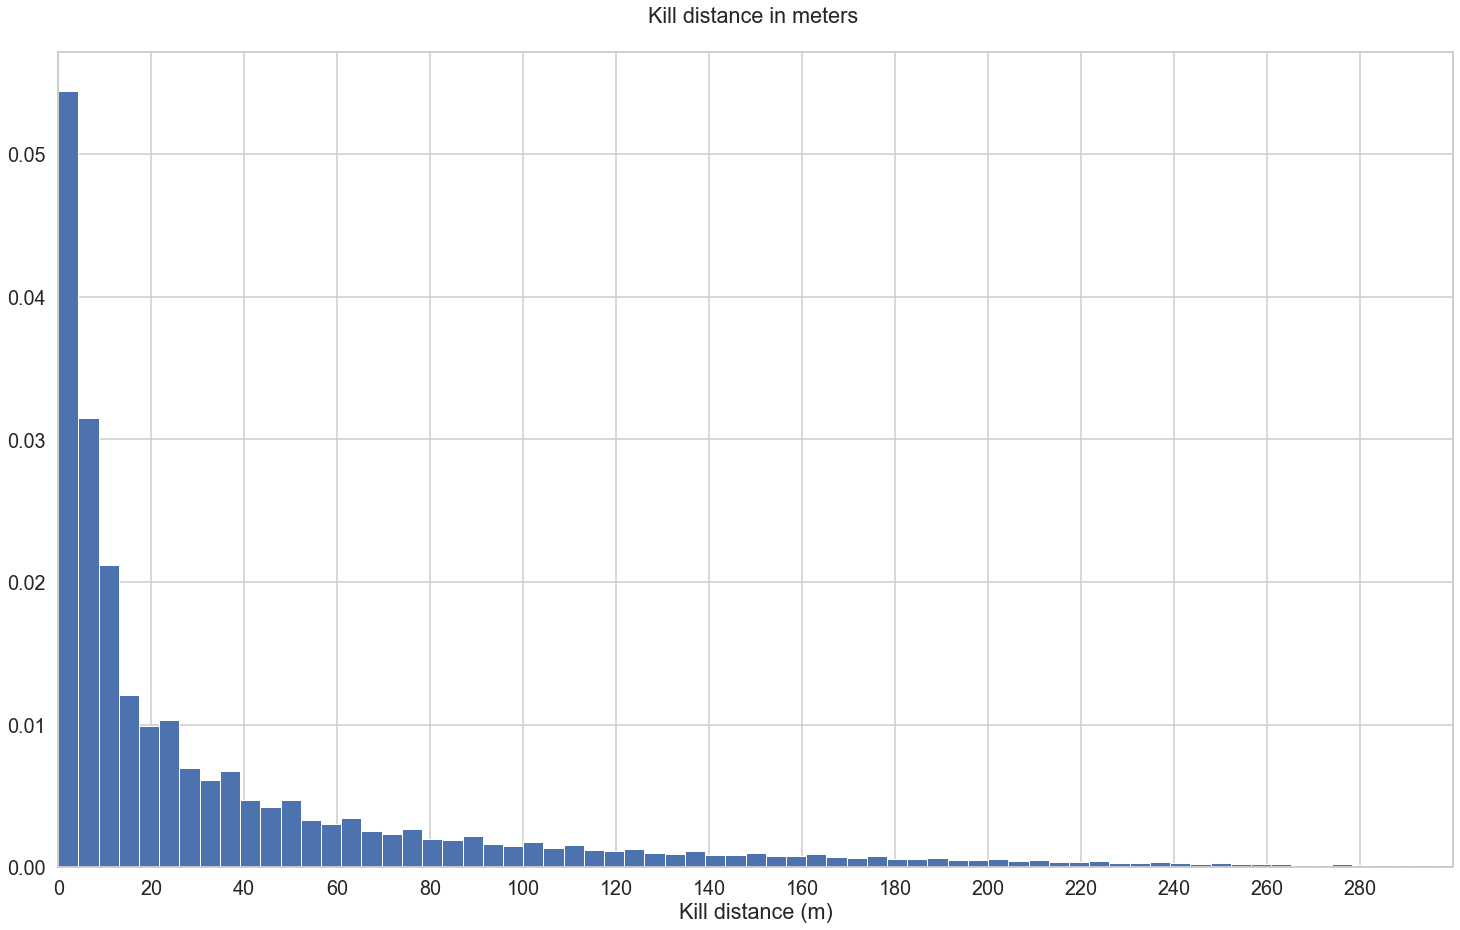

In [25]:
plt.figure(figsize=(25,15))
sns.set(style='whitegrid', context='talk', font_scale=1.2)
plt.hist(deaths_df["kill_distance"], density=True, bins=2000, edgecolor='white', linewidth=1)
plt.xlabel('Kill distance (m)')
plt.title("Kill distance in meters \n")
plt.xlim(0, 300)
plt.xticks(np.arange(0, 300, 20));

In [26]:
deaths_df.sort_values(by = 'kill_distance', ascending=False, inplace=False).head(100)

,killer_position_x,killer_position_y,map,time,victim_position_x,victim_position_y,phase,kill_distance
13616617,795422.4,18904.32,ERANGEL,453,69320.38,497317.6,early,8695.0
13773717,793556.9,24322.42,ERANGEL,322,170264.60,627961.5,early,8677.0
39785003,796336.9,19021.32,ERANGEL,57,439893.00,637802.9,very_early,7141.0
32236186,797778.3,19156.57,ERANGEL,302,379823.20,577966.6,early,6978.0
18779425,796676.6,20689.65,ERANGEL,50,211654.10,354569.7,very_early,6736.0
...,...,...,...,...,...,...,...,...
58596936,495082.2,264202.60,ERANGEL,704,328104.90,284175.5,early,1682.0
64304439,383152.8,405434.90,ERANGEL,882,522592.10,499345.7,mid,1681.0
59694825,262367.3,389470.00,ERANGEL,213,213962.10,229120.4,early,1675.0
57350727,331272.4,288981.90,ERANGEL,993,373519.40,127367.3,mid,1670.0
